#  BERT for sentiment classification 

Some figures are adapted from [_The Illustrated BERT, ELMo, and co._](https://jalammar.github.io/illustrated-bert/) by Jay Alammar.

In [ ]:
!pip3 install torch torchtext numpy matplotlib datasets adapter-transformers

In [27]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 1 - Introduction to BERT

[BERT](https://arxiv.org/abs/1810.04805) has been wildly successful on a variety of tasks in NLP. They compute vector-space representations of natural language that are suitable for use in many downstream tasks. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT is pretrained with masked language modeling task. Masked language modeling task is a type of cloze tasks where some words are masked out and the jobs of the model is to predict the original words.

![cloze](https://jalammar.github.io/images/BERT-language-modeling-masked-lm.png)


In this tutorial, we will learn to finetune the pretrained BERT for text classification problem.

### BERT Tokenizer
We will first learn to process raw text sentence into the proper inputs for BERT using BERTTokenizer. We will use BERT base architecture(_bert-base-uncased_) in this tutorial. There are [other pretrained models](https://huggingface.co/models) available as well.


In [18]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

To handle huge numbers of vocabulary, BERT use subword units (called _wordpiece_) instead of word-level vocabulary. The idea is to break up rare words into smaller and more frequent units (subwords), hence reduces the amount of unknown words.

In [4]:
tokenizer.vocab.keys()

odict_keys(['[PAD]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[unused31]', '[unused32]', '[unused33]', '[unused34]', '[unused35]', '[unused36]', '[unused37]', '[unused38]', '[unused39]', '[unused40]', '[unused41]', '[unused42]', '[unused43]', '[unused44]', '[unused45]', '[unused46]', '[unused47]', '[unused48]', '[unused49]', '[unused50]', '[unused51]', '[unused52]', '[unused53]', '[unused54]', '[unused55]', '[unused56]', '[unused57]', '[unused58]', '[unused59]', '[unused60]', '[unused61]', '[unused62]', '[unused63]', '[unused64]', '[unused65]', '[unused66]', '[unused67]', '[unused68]', '[unused69]', '[unused7

In [5]:
tokenizer.tokenize("Everybody knows bidirectional conditioning would allow each word to indirectly see itself in a multi-layered context.") 

['everybody',
 'knows',
 'bid',
 '##ire',
 '##ction',
 '##al',
 'conditioning',
 'would',
 'allow',
 'each',
 'word',
 'to',
 'indirectly',
 'see',
 'itself',
 'in',
 'a',
 'multi',
 '-',
 'layered',
 'context',
 '.']

Let's convert this sentence to tensors so that BERT can consume.

In [6]:
inputs = tokenizer("Everybody knows bidirectional conditioning would allow each word to indirectly see itself in a multi-layered context.")
inputs

{'input_ids': [101, 7955, 4282, 7226, 7442, 7542, 2389, 14372, 2052, 3499, 2169, 2773, 2000, 17351, 2156, 2993, 1999, 1037, 4800, 1011, 21323, 6123, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [19]:
from transformers import BertForPreTraining
model = BertForPreTraining.from_pretrained("bert-base-uncased")

Some weights of BertForPreTraining were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading BERT from HuggingFace transformers library.

In [20]:
from transformers import BertModel
bert = BertModel.from_pretrained("bert-base-uncased")
bert

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (shared_parameters): ModuleDict()
  (invertible_adapters): ModuleDict()
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (prefix_tuning): PrefixTuningShim(
              (pool): PrefixTuningPool(
                (prefix_tunings): ModuleDict()
              )
            )
          )
          (out

In [24]:
def count_parameters(model):
    total  = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters {trainable}/{total}")

In [10]:
count_parameters(model)

Trainable parameters 110106428/110106428


## Part 2 - BERT for text classification

We will use BERT to train a spam detection classifier on `sms_spam` dataset. Let's load the dataset from [Huggingface datasets](https://huggingface.co/docs/datasets/index) and inspect the dataset.

In [ ]:
from datasets import load_dataset
sms = load_dataset("sms_spam")

In [2]:
sms["train"][0]

{'label': 0,
 'sms': 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n'}

In [3]:
sms

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 5574
    })
})

The sms_spam dataset contains 5574 training examples and do not have any validation and testset associated. We will split 1000 examples as validation set for model selection.

In [4]:
train_valid_dict = sms['train'].train_test_split(test_size=1000, shuffle=True, seed=123)
train_valid_dict

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 4574
    })
    test: Dataset({
        features: ['sms', 'label'],
        num_rows: 1000
    })
})

In [5]:
train_dataset = train_valid_dict['train']
valid_dataset = train_valid_dict['test']

In [6]:
train_dataset

Dataset({
    features: ['sms', 'label'],
    num_rows: 4574
})

In [7]:
valid_dataset

Dataset({
    features: ['sms', 'label'],
    num_rows: 1000
})

We will use BertTokenizer to tokenize the dataset and create dataloaders.

In [13]:
import torch

In [14]:
### tokenize dataset and create dataloader
def tokenize_and_create_dataloader(dataset, shuffle=True, batch_size=8):
    dataset = dataset.rename_column('label', 'labels')
    dataset = dataset.map(lambda e: tokenizer(e['sms'], truncation=True, padding='max_length'), batched=True)
    dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

train_dataloader = tokenize_and_create_dataloader(train_dataset)
valid_dataloader = tokenize_and_create_dataloader(valid_dataset, shuffle=False)

Loading cached processed dataset at /root/.cache/huggingface/datasets/sms_spam/plain_text/1.0.0/53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c/cache-65afa8994f94467a.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

In [15]:
next(iter(train_dataloader))

{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'input_ids': tensor([[  101,  2204,  1012,  ...,     0,     0,     0],
         [  101,  1045,  1005,  ...,     0,     0,     0],
         [  101,  1045,  1005,  ...,     0,     0,     0],
         ...,
         [  101, 14145,  2080,  ...,     0,     0,     0],
         [  101,  2469,  2021,  ...,     0,     0,     0],
         [  101,  2129,  2106,  ...,     0,     0,     0]]),
 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]])}

#### Finetuning BERT

The pretrained BERT provides feature representation of the given input. To use BERT for text classification, a classifier is added on top of BERT to predict the class label given the feature extracted by BERT. The classifier is usually a one-layer feed forward network followed by a softmax layer. The first output of BERT corresponding to the first token in the input (**[CLS]**) is used as the input to the classifier.


![finetuning](https://jalammar.github.io/images/bert-classifier.png)

We now define our classifer MyBertForSequenceClassification model. This implementation is adapted from BertForSequenceClassification model in huggingface transformers library with some obmitted details for illustration purpose.

In [16]:
import torch
import torch.nn as nn
from transformers import BertPreTrainedModel
from typing import List, Optional, Tuple, Union

class MyBertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.bert = BertModel(config)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.init_weights()
        
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits, outputs

In [21]:
model = MyBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing MyBertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing MyBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyBertForSequenceClassification were not initialized from the model check

In [22]:
model

MyBertForSequenceClassification(
  (bert): BertModel(
    (shared_parameters): ModuleDict()
    (invertible_adapters): ModuleDict()
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (prefix_tuning): PrefixTuningShim(
                (pool): PrefixTuningPool(
                  (p

In [25]:
count_parameters(model)

Trainable parameters 109483778/109483778


Let take a look into the model output

In [28]:
batch = next(iter(train_dataloader))
batch = {k: v.to(device) for k, v in batch.items()}
model.to(device)
outputs = model(**batch)
outputs

(tensor([[ 0.1789, -0.0224],
         [ 0.4072,  0.1287],
         [ 0.2268,  0.0664],
         [ 0.3116, -0.0427],
         [ 0.3225, -0.0212],
         [ 0.3390,  0.0223],
         [ 0.3463,  0.0511],
         [ 0.2727, -0.1566]], device='cuda:0', grad_fn=<AddmmBackward0>),
 BaseModelOutputWithPoolingAndCrossAttentions([('last_hidden_state',
                                                tensor([[[-0.0769,  0.1937, -0.3338,  ..., -0.5710,  0.2593,  0.3583],
                                                         [ 0.1374, -0.0499,  0.5627,  ..., -0.5415,  0.7170, -0.2493],
                                                         [ 0.0302, -0.0515,  0.3874,  ..., -0.7065, -0.0927, -0.2982],
                                                         ...,
                                                         [-0.2385, -0.3429,  0.1231,  ...,  0.2292,  0.0366, -0.2076],
                                                         [ 0.0880, -0.2386,  0.4422,  ...,  0.0630,  0.0386, -0.0437

Training loop

In [29]:
from tqdm import tqdm
loss_fn = nn.CrossEntropyLoss()
num_labels = 2


def validate(epoch, model):
    loss_sum = 0
    valid_size = len(valid_dataset)
    with torch.no_grad():
        for i, batch in enumerate(tqdm(valid_dataloader)):
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch['labels']
            logits = outputs[0]
            loss = loss_fn(logits.view(-1, num_labels), labels.view(-1))
            loss_sum += loss.item()
    loss_sum /= valid_size
    print(f"Valid loss: {loss_sum}")
    
def train_one_epoch(epoch, model, optimizer):
    plot_losses = []
    for i, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']
        outputs = model(**batch)
        logits = outputs[0]
        loss = loss_fn(logits.view(-1, num_labels), labels.view(-1))
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"loss: {loss}")
            plot_losses.append(loss.cpu().item())
    print(f"loss: {loss}")
    validate(epoch, model)
    return plot_losses

In [30]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline
    
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [31]:
import time
def train_iters(model, num_epochs=2, learning_rate=5e-5):
  start = time.time()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  plot_losses = []
  for iter in range(1, num_epochs + 1):
    losses = train_one_epoch(iter, model, optimizer)
    plot_losses.extend(losses)
  elapsed = time.time() - start
  print(f"Finish training in {elapsed} seconds ({time.strftime('%H:%M:%S', time.gmtime(elapsed))})")
  showPlot(plot_losses)


  0%|          | 1/572 [00:01<13:44,  1.44s/it]

loss: 0.6423611640930176


 18%|█▊        | 101/572 [02:14<10:40,  1.36s/it]

loss: 0.012480862438678741


 35%|███▌      | 201/572 [04:27<08:20,  1.35s/it]

loss: 0.018549101427197456


 53%|█████▎    | 301/572 [06:41<06:03,  1.34s/it]

loss: 0.002374887466430664


 70%|███████   | 401/572 [08:54<03:49,  1.34s/it]

loss: 0.006853816565126181


 88%|████████▊ | 501/572 [11:08<01:35,  1.34s/it]

loss: 0.006559280678629875


100%|██████████| 572/572 [12:42<00:00,  1.33s/it]


loss: 0.06563235074281693


100%|██████████| 125/125 [00:00<00:00, 182.41it/s]


Valid loss: 0.07456368941068649


  0%|          | 1/572 [00:01<12:42,  1.34s/it]

loss: 0.005928687751293182


 18%|█▊        | 101/572 [02:14<10:32,  1.34s/it]

loss: 0.0028384742327034473


 35%|███▌      | 201/572 [04:27<08:17,  1.34s/it]

loss: 0.0031062704510986805


 53%|█████▎    | 301/572 [06:41<06:04,  1.34s/it]

loss: 0.003994924481958151


 70%|███████   | 401/572 [08:54<03:49,  1.34s/it]

loss: 0.0053444006480276585


 88%|████████▊ | 501/572 [11:07<01:35,  1.34s/it]

loss: 0.0039217215962708


100%|██████████| 572/572 [12:42<00:00,  1.33s/it]


loss: 0.0029615259263664484


100%|██████████| 125/125 [00:00<00:00, 187.23it/s]


Valid loss: 0.07456368941068649
Finish training in 1526.2948710918427 seconds (00:25:26)


<Figure size 432x288 with 0 Axes>

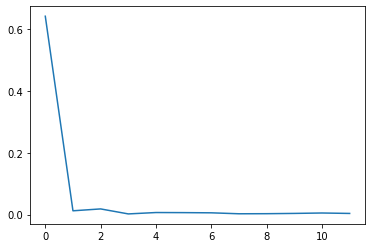

In [32]:
train_iters(model)

In [33]:
model.cpu()
torch.cuda.empty_cache()

### Freezing BERT layers
Freezing layers means disabling gradient computation and backpropagation for the weights of these layers. It is a common technique to reduce overfit of a pretrained model on small dataset as well as reduce the computation cost. The bottom layers often encode universal features while the top layers captures task-specific informations. Therefore, we often freeze the bottom layers and only finetune a few top layers on downstream task.

In [34]:
def freeze_module_params(m):
    if m is not None:
        for p in m.parameters():
            p.requires_grad = False

Freeze the bottom 10 layers

In [35]:
freeze_model = MyBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
for i in range(10):
    freeze_module_params(freeze_model.bert.encoder.layer[i])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing MyBertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing MyBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyBertForSequenceClassification were not initialized from the model check

In [36]:
count_parameters(freeze_model)

Trainable parameters 38605058/109483778


Train freeze models

  0%|          | 1/572 [00:01<11:07,  1.17s/it]

loss: 0.5333032011985779


 18%|█▊        | 101/572 [01:45<08:16,  1.05s/it]

loss: 0.005200885236263275


 35%|███▌      | 201/572 [03:30<06:30,  1.05s/it]

loss: 0.576810359954834


 53%|█████▎    | 301/572 [05:15<04:45,  1.05s/it]

loss: 0.02321488969027996


 70%|███████   | 401/572 [07:00<03:00,  1.06s/it]

loss: 0.021850798279047012


 88%|████████▊ | 501/572 [08:44<01:14,  1.05s/it]

loss: 0.003393069375306368


100%|██████████| 572/572 [09:58<00:00,  1.05s/it]


loss: 0.0012984712375327945


100%|██████████| 125/125 [00:00<00:00, 191.26it/s]


Valid loss: 0.07456368941068649


  0%|          | 1/572 [00:01<10:02,  1.05s/it]

loss: 0.0012465919135138392


 18%|█▊        | 101/572 [01:45<08:16,  1.05s/it]

loss: 0.001112085417844355


 35%|███▌      | 201/572 [03:30<06:25,  1.04s/it]

loss: 0.00043935218127444386


 53%|█████▎    | 301/572 [05:15<04:45,  1.05s/it]

loss: 0.0006123420316725969


 70%|███████   | 401/572 [07:00<03:00,  1.05s/it]

loss: 0.000582114967983216


 88%|████████▊ | 501/572 [08:44<01:14,  1.05s/it]

loss: 0.0002832615573424846


100%|██████████| 572/572 [09:58<00:00,  1.05s/it]


loss: 0.00016731326468288898


100%|██████████| 125/125 [00:00<00:00, 191.65it/s]


Valid loss: 0.07456368941068649
Finish training in 1199.3290600776672 seconds (00:19:59)


<Figure size 432x288 with 0 Axes>

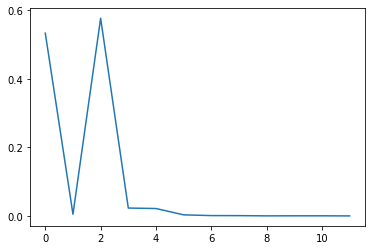

In [37]:
freeze_model.to(device)
train_iters(freeze_model)

In [38]:
freeze_model.cpu()
torch.cuda.empty_cache()

### Adapters
Adapter is an alternative method to fine-tuning BERT model on downstream tasks. Adapter is a lightweight feedforward layer added to every BERT layer to fast adapt BERT representation to the downstream task. While training adapters, other BERT parameters are frozen, i.e. not updated.

In [39]:
from transformers import BertConfig, BertForSequenceClassification 

config = BertConfig.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
)
adapter_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    config=config,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [40]:
adapter_model.add_adapter('sms')

In [41]:
adapter_model

BertForSequenceClassification(
  (shared_parameters): ModuleDict()
  (bert): BertModel(
    (shared_parameters): ModuleDict()
    (invertible_adapters): ModuleDict()
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (prefix_tuning): PrefixTuningShim(
                (pool): Pref

In [42]:
adapter_model.train_adapter('sms')

In [43]:
count_parameters(adapter_model)

Trainable parameters 896066/110378306


In [44]:
batch = next(iter(train_dataloader))
batch = {k: v.to(device) for k, v in batch.items()}
adapter_model.to(device)
outputs = adapter_model(**batch)
outputs

SequenceClassifierOutput([('loss',
                           tensor(0.7119, device='cuda:0', grad_fn=<NllLossBackward0>)),
                          ('logits', tensor([[ 0.0955, -0.0467],
                                   [ 0.2030,  0.3017],
                                   [ 0.0926, -0.0714],
                                   [ 0.1796,  0.1817],
                                   [ 0.1202,  0.3452],
                                   [ 0.1365,  0.1817],
                                   [ 0.1443,  0.2251],
                                   [ 0.1555,  0.2766]], device='cuda:0', grad_fn=<AddmmBackward0>))])

Training

In [45]:
from tqdm import tqdm
loss_fn = nn.CrossEntropyLoss()
num_labels = 2


def validate_adapter(epoch, model):
    loss_sum = 0
    valid_size = len(valid_dataset)
    with torch.no_grad():
        for i, batch in enumerate(tqdm(valid_dataloader)):
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = outputs.logits
            loss = outputs.loss
            loss_sum += loss.item()
    loss_sum /= valid_size
    print(f"Valid loss: {loss_sum}")
    
def train_adapter_one_epoch(epoch, model, optimizer):
    plot_losses = []
    for i, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        loss = outputs.loss
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"loss: {loss}")
            plot_losses.append(loss.cpu().item())
    print(f"loss: {loss}")
    validate_adapter(epoch, model)
    return plot_losses

In [46]:
import time
def train_adapter_iters(model, num_epochs=2, learning_rate=5e-5):
  start = time.time()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  plot_losses = []
  for iter in range(1, num_epochs + 1):
    losses = train_adapter_one_epoch(iter, model, optimizer)
    plot_losses.extend(losses)
  elapsed = time.time() - start
  print(f"Finish training in {elapsed} seconds ({time.strftime('%H:%M:%S', time.gmtime(elapsed))})")
  showPlot(plot_losses)


  0%|          | 2/1144 [00:00<04:18,  4.42it/s]

loss: 0.7726459503173828


  9%|▉         | 102/1144 [00:27<04:37,  3.76it/s]

loss: 0.11909793317317963


 18%|█▊        | 202/1144 [00:55<04:06,  3.82it/s]

loss: 0.024516820907592773


 26%|██▋       | 302/1144 [01:22<03:37,  3.87it/s]

loss: 0.013657861389219761


 35%|███▌      | 402/1144 [01:49<03:14,  3.81it/s]

loss: 0.8182166218757629


 44%|████▍     | 502/1144 [02:16<02:47,  3.83it/s]

loss: 0.014145995490252972


 53%|█████▎    | 602/1144 [02:43<02:21,  3.83it/s]

loss: 0.004147657658904791


 61%|██████▏   | 702/1144 [03:10<01:55,  3.83it/s]

loss: 0.010353734716773033


 70%|███████   | 802/1144 [03:38<01:29,  3.83it/s]

loss: 0.012379269115626812


 79%|███████▉  | 902/1144 [04:05<01:03,  3.83it/s]

loss: 0.008748413063585758


 88%|████████▊ | 1002/1144 [04:32<00:36,  3.84it/s]

loss: 0.011383628472685814


 96%|█████████▋| 1102/1144 [04:59<00:10,  3.83it/s]

loss: 0.00595221808180213


100%|██████████| 1144/1144 [05:11<00:00,  3.68it/s]


loss: 0.005703316070139408


100%|██████████| 250/250 [00:00<00:00, 559.57it/s]


Valid loss: 0.20562061667442322


  0%|          | 2/1144 [00:00<03:45,  5.07it/s]

loss: 0.0033437423408031464


  9%|▉         | 102/1144 [00:27<04:32,  3.83it/s]

loss: 0.0037111861165612936


 18%|█▊        | 202/1144 [00:54<04:06,  3.81it/s]

loss: 0.008923877030611038


 26%|██▋       | 302/1144 [01:21<03:40,  3.83it/s]

loss: 0.003330270294100046


 35%|███▌      | 402/1144 [01:49<03:12,  3.85it/s]

loss: 0.021935345605015755


 44%|████▍     | 502/1144 [02:16<02:47,  3.83it/s]

loss: 0.0027652315329760313


 53%|█████▎    | 602/1144 [02:43<02:20,  3.85it/s]

loss: 0.003273406531661749


 61%|██████▏   | 702/1144 [03:10<01:55,  3.83it/s]

loss: 0.006506465841084719


 70%|███████   | 802/1144 [03:37<01:29,  3.84it/s]

loss: 0.004990917164832354


 79%|███████▉  | 902/1144 [04:04<01:03,  3.83it/s]

loss: 0.00619067158550024


 88%|████████▊ | 1002/1144 [04:32<00:37,  3.84it/s]

loss: 0.003377852961421013


 96%|█████████▋| 1102/1144 [04:59<00:10,  3.82it/s]

loss: 0.005156002473086119


100%|██████████| 1144/1144 [05:10<00:00,  3.68it/s]


loss: 0.004065736662596464


100%|██████████| 250/250 [00:00<00:00, 590.12it/s]

Valid loss: 0.20562061667442322
Finish training in 622.7439098358154 seconds (00:10:22)


<Figure size 432x288 with 0 Axes>

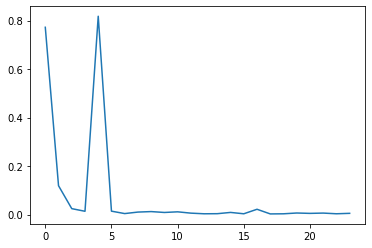

In [ ]:
adapter_model.to(device)
train_adapter_iters(adapter_model)

## Exercises
1. Calculate accuracy on validation set of Fully-finetune BERT, freeze some layer BERT and adapter models.
2. Investigate the effect of freezing different layers, i.e. the bottom 3, 5, 7 or all 12 BERT layers on our spam detection classifier.
3. Can we use our 'sms' adapter for spam detection of other dataset, e.g [Eron_spam](https://huggingface.co/datasets/SetFit/enron_spam)?